In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import contextlib
import logging
import openbabel
from openbabel import pybel
import rdkit
import os
import sys

from random import randrange
from rdkit import Chem, RDLogger
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem import AllChem, rdMolAlign, Descriptors, Draw
from rdkit.Chem.rdchem import Mol
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import rdFMCS, MolFromSmarts
from selfies import encoder, decoder 
from rdkit.Chem.Draw import MolToImage, IPythonConsole, rdMolDraw2D

import lomap

# Get the current working directory
current_dir = os.getcwd()

# Get the absolute path to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

# Now you can import the module
from generator import fingerprint
from generator import generation
from generator import filters
from generator import scoring
from generator import visualization

In [ ]:
def find_mcs(smiles_1, smiles_2):
    """
    Find the maximum common substructure (MCS) of two molecules.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    rdkit.Chem.rdchem.Mol: The MCS of the two molecules.
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    template = Chem.MolFromSmarts(mcs.smartsString)

    return template

In [27]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

def find_mcs_and_rgroups_with_tags(smiles_1, smiles_2):
    """
    Find the maximum common substructure (MCS) of two molecules and return R-groups as separate SMILES, with
    tags for the positions where R-groups are connected to the MCS.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (MCS_SMILES_with_tags, Rgroups_smiles_1_with_tags, Rgroups_smiles_2_with_tags)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Create submolecules for R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)

    # Validate atom indices before tagging
    for idx in atoms_a:
        if idx < rgroup_a.GetNumAtoms():  # Ensure the index is within bounds
            rgroup_a.GetAtomWithIdx(idx).SetProp('atomNote', 'R_A')  # Tag R-group side in mol_a
    for idx in atoms_b:
        if idx < rgroup_b.GetNumAtoms():  # Ensure the index is within bounds
            rgroup_b.GetAtomWithIdx(idx).SetProp('atomNote', 'R_B')  # Tag R-group side in mol_b

    # Convert R-groups and MCS to SMILES (with tags)
    rgroup_smiles_1 = Chem.MolToSmiles(rgroup_a)
    rgroup_smiles_2 = Chem.MolToSmiles(rgroup_b)
    mcs_smiles = Chem.MolToSmiles(template)

    return mcs_smiles, rgroup_smiles_1, rgroup_smiles_2

In [32]:
liga_smiles = "CC(=O)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1" #tyk2-42
ligb_smiles = "CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1" #tyk2-44
num_tries = 2
num_random_smiles = 2
num_random_samples = 2
collect_bidirectional = True
exponent_path = 1
n_rounds = 1
fp_type = "ECFP4"

mcs, r1, r2 = find_mcs_and_rgroups_with_tags(liga_smiles, ligb_smiles)
print(mcs, r1, r2)
r1

CCC(=O)NC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1 CC CCC


'CC'

In [35]:
def get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    '''Obtain multiple paths/chemical paths from starting_smile to target_smile. 
    
    Parameters:
    starting_smile (string)     : SMILES string (needs to be a valid molecule)
    target_smile (int)          : SMILES string (needs to be a valid molecule)
    num_tries (int)             : Number of path/chemical path attempts between the exact same smiles
    num_random_samples (int)    : Number of different SMILES string orderings to consider for starting_smile & target_smile 
    collect_bidirectional (bool): If True, forms paths from target_smiles-> target_smiles (doubles the number of paths)
    fp_type (string)            : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6) 

    Returns:
    smiles_paths_dir1 (list): List of paths containing SMILES in the path between starting_smile -> target_smile
    smiles_paths_dir2 (list): List of paths containing SMILES in the path between target_smile -> starting_smile
    '''
    starting_smile_rand_ord = generation.get_random_smiles(starting_smile, num_random_samples=num_random_samples)
    target_smile_rand_ord = generation.get_random_smiles(target_smile, num_random_samples=num_random_samples)
    
    smiles_paths_dir1 = [] # All paths from starting_smile -> target_smile
    for smi_start in starting_smile_rand_ord: 
        for smi_target in target_smile_rand_ord: 
            
            if Chem.MolFromSmiles(smi_start) is None or Chem.MolFromSmiles(smi_target) is None: 
                raise Exception('Invalid structures')
                
            for _ in range(num_tries):
                path, _, _, _ = generation.obtain_path(smi_start, smi_target, filter_path=True, fp_type=fp_type)
                smiles_paths_dir1.append(path)
    
    smiles_paths_dir2 = [] # All paths from starting_smile -> target_smile
    if collect_bidirectional: 
        starting_smile_rand_ord = generation.get_random_smiles(target_smile, num_random_samples=num_random_samples)
        target_smile_rand_ord = generation.get_random_smiles(starting_smile, num_random_samples=num_random_samples)
        
        for smi_start in starting_smile_rand_ord: 
            for smi_target in target_smile_rand_ord: 
                
                if Chem.MolFromSmiles(smi_start) is None or Chem.MolFromSmiles(smi_target) is None: 
                    raise Exception('Invalid structures')
        
            for _ in range(num_tries):
                path, _, _, _ = generation.obtain_path(smi_start, smi_target, filter_path=True)
                smiles_paths_dir2.append(path)
                    
    return smiles_paths_dir1, smiles_paths_dir2


In [36]:
get_compr_paths(r1, r2, num_tries, num_random_samples, collect_bidirectional, fp_type)

([['CC', 'CCC'], ['CC', 'CCC']], [['CCC', 'CC'], ['CCC', 'CC']])

In [49]:

from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem

def find_mcs_and_tagged_rgroups(smiles_1, smiles_2):
    """
    Find the Maximum Common Substructure (MCS) and return the MCS with tags and the unique R-groups.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (MCS (rdkit Mol), R-groups from mol1, R-groups from mol2, mapped positions in mol1, mapped positions in mol2, match_a, match_b)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Create submolecules for the R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)
    
    # Map original atom indices to submolecule atom indices
    original_to_sub_a = {original: idx for idx, original in enumerate(atoms_a)}
    original_to_sub_b = {original: idx for idx, original in enumerate(atoms_b)}

    return template, rgroup_a, rgroup_b, original_to_sub_a, original_to_sub_b, match_a, match_b


def glue_rgroup_to_mcs_with_tags(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position.
    
    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.
    
    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)
    
    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)
    
    # Add a bond between the tagged atoms
    editable_combined.AddBond(mcs_tag, rgroup_tag + mcs.GetNumAtoms(), order=Chem.BondType.SINGLE)
    
    # Get the final molecule
    final_molecule = editable_combined.GetMol()
    
    # Sanitize the molecule to ensure it's valid
    Chem.SanitizeMol(final_molecule)
    
    return final_molecule

def get_compr_paths_with_rgroup_gluing_and_tags(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    """
    Obtain multiple paths/chemical paths from starting_smile to target_smile, extract R-groups,
    glue them back onto the MCS using tagged positions, and print the resulting molecules.
    
    Parameters:
    starting_smile (string): SMILES string of the starting molecule.
    target_smile (string): SMILES string of the target molecule.
    num_tries (int): Number of path attempts.
    num_random_samples (int): Number of random samples to consider.
    collect_bidirectional (bool): If True, also form paths from target_smile to starting_smile.
    fp_type (string): Type of fingerprint.
    
    Returns:
    list: Unique reconstructed molecules (SMILES strings).
    """
    # Obtain paths (This uses your previous `get_compr_paths` function)
    smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type)
    
    # Combine the two lists of paths
    combined_paths = smiles_paths_dir1 + smiles_paths_dir2
    
    # Remove duplicates
    unique_paths = list(set(tuple(path) for path in combined_paths))
    
    # Find the MCS and extract R-groups along with the tagged positions and match arrays
    mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_tagged_rgroups(starting_smile, target_smile)
    
    # Reconstructed molecules
    reconstructed_molecules = []
    
    print("Gluing R-groups back onto the MCS at the correct positions:")
    
    # Attach R-group 1 to the MCS at the correct tagged position
    # Select the first valid key in map_a instead of assuming 0
    rgroup_1_idx = next(iter(map_a.keys()))  # Use the first key in map_a
    mol_with_rgroup_1 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_1, map_a[rgroup_1_idx], match_a[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_1))
    
    # Attach R-group 2 to the MCS at the correct tagged position
    rgroup_2_idx = next(iter(map_b.keys()))  # Use the first key in map_b
    mol_with_rgroup_2 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_2, map_b[rgroup_2_idx], match_b[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_2))
    
    # Print the reconstructed molecules
    for idx, molecule in enumerate(reconstructed_molecules):
        print(f"Reconstructed Molecule {idx+1}: {molecule}")
    
    return reconstructed_molecules




In [50]:
get_compr_paths_with_rgroup_gluing_and_tags(liga_smiles, ligb_smiles, num_tries, num_random_samples, collect_bidirectional, fp_type)

Gluing R-groups back onto the MCS at the correct positions:
Reconstructed Molecule 1: CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
Reconstructed Molecule 2: CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1


['CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1',
 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1']

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1076823/1919421708.py:37: SyntaxWarning: invalid escape sequence '\l'
  titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
/tmp/ipykernel_1076823/1919421708.py:37: SyntaxWarning: invalid escape sequence '\l'
  titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]


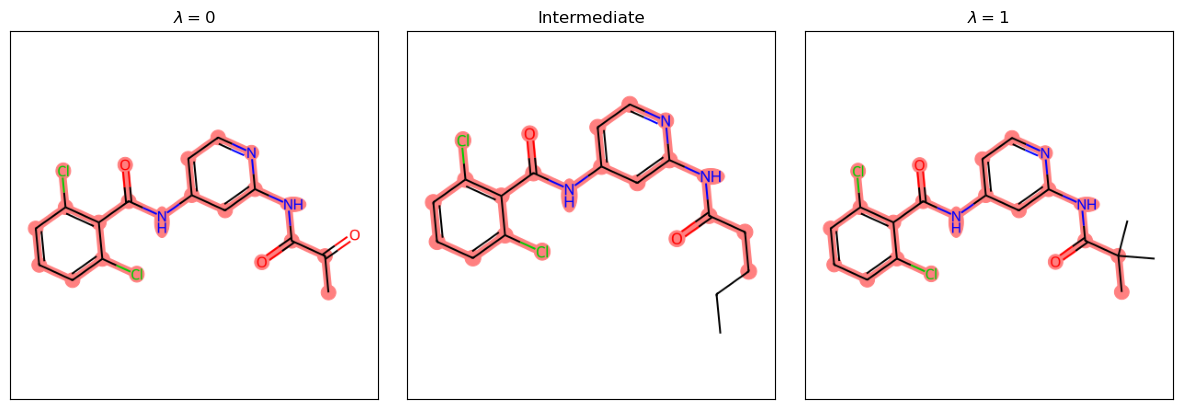

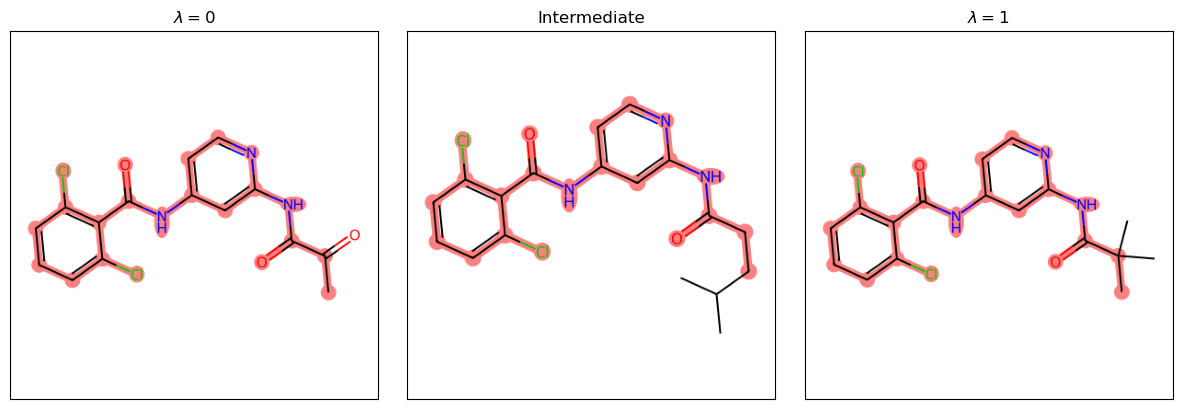

In [51]:
def visualise(liga_smiles, ligb_smiles, selected_intermediate_smiles):
    """
    Visualise and save an image of three aligned ligands with the Maximum Common Substructure (MCS) highlighted.
    
    Args:
        liga_smiles, ligb_smiles, selected_intermediate_smiles (str): The SMILES strings for the ligands to visualize.
        mins, secs (int): The minutes and seconds elapsed.
        filepath (str): The path to the location where the image is to be saved.
        filename (str): The name of the file.
    """
    # get intermediate
    liga = Chem.MolFromSmiles(liga_smiles)
    ligb = Chem.MolFromSmiles(ligb_smiles)
    intermediate = Chem.MolFromSmiles(selected_intermediate_smiles)

    # find MCS of the 3 molecules
    mcs_mol = filters.find_mcs_3_mols(liga_smiles, ligb_smiles, selected_intermediate_smiles)

    # Align ligands 
    molecules = visualization.alignLigands(liga, intermediate, ligb)

    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

    # Generate the images with the MCS highlighted
    img0 = visualization.draw_molecule_with_mcs(liga, mcs_mol)
    img1 = visualization.draw_molecule_with_mcs(intermediate, mcs_mol)
    img2 = visualization.draw_molecule_with_mcs(ligb, mcs_mol)

    # Plot the images
    axes[0].imshow(img0)
    axes[1].imshow(img1)
    axes[2].imshow(img2)


    # Turn off axes and set titles.
    titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
    for ax, title in zip(axes, titles):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(title)

    # set spacing between plots
    plt.subplots_adjust(wspace=0.08)



    plt.show()


visualise(liga_smiles, ligb_smiles, 'CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
visualise(liga_smiles, ligb_smiles, 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')

The code above is able to succesfully glue logical stuff back at the right location. however, the tag is probably wrong, since the glue position is not correct. 

In [59]:
from rdkit import Chem
from rdkit.Chem import rdFMCS

def find_mcs_and_tagged_rgroups(smiles_1, smiles_2):
    """
    Find the Maximum Common Substructure (MCS) and return the MCS with tags and the unique R-groups.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    tuple: (MCS (rdkit Mol), R-groups from mol1, R-groups from mol2, mapped positions in mol1, mapped positions in mol2, match_a, match_b)
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    # Find the MCS
    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    
    template = Chem.MolFromSmarts(mcs.smartsString)
    mcs_smiles = Chem.MolToSmiles(template)
    print("this is the smiles of the mcs:", mcs_smiles)
    
    # Get substructure matches for both molecules
    match_a = mol_a.GetSubstructMatch(template)
    match_b = mol_b.GetSubstructMatch(template)
    
    # Get atoms not in the match (R-groups)
    atoms_a = [atom.GetIdx() for atom in mol_a.GetAtoms() if atom.GetIdx() not in match_a]
    atoms_b = [atom.GetIdx() for atom in mol_b.GetAtoms() if atom.GetIdx() not in match_b]

    # Create submolecules for the R-groups
    rgroup_a = Chem.PathToSubmol(mol_a, atoms_a)
    rgroup_b = Chem.PathToSubmol(mol_b, atoms_b)

    # Map original atom indices to submolecule atom indices (renumbered)
    original_to_sub_a = {original: idx for idx, original in enumerate(atoms_a)}
    original_to_sub_b = {original: idx for idx, original in enumerate(atoms_b)}

    # We no longer need to tag atoms using the original indices, because the submolecules are renumbered.
    return template, rgroup_a, rgroup_b, original_to_sub_a, original_to_sub_b, match_a, match_b

def glue_rgroup_to_mcs_with_tags(mcs, rgroup, rgroup_tag, mcs_tag):
    """
    Attach the R-group back to the MCS at the correct tagged position.
    
    Args:
    mcs (rdkit Mol): The Maximum Common Substructure.
    rgroup (rdkit Mol): The R-group to attach.
    rgroup_tag (int): The atom index in the R-group to attach.
    mcs_tag (int): The atom index in the MCS where the R-group attaches.
    
    Returns:
    rdkit Mol: The reconstructed molecule.
    """
    # Print atom indices to check if they are correct
    print(f"Gluing R-group at atom {rgroup_tag} to MCS at atom {mcs_tag}")

    # Combine the MCS and R-group into a single molecule
    combined = Chem.CombineMols(mcs, rgroup)
    
    # Create an editable molecule
    editable_combined = Chem.EditableMol(combined)
    
    # Add a bond between the tagged atoms
    editable_combined.AddBond(mcs_tag, rgroup_tag + mcs.GetNumAtoms(), order=Chem.BondType.SINGLE)
    
    # Get the final molecule
    final_molecule = editable_combined.GetMol()
    
    # Sanitize the molecule to ensure it's valid
    Chem.SanitizeMol(final_molecule)
    
    return final_molecule

def get_compr_paths_with_rgroup_gluing_and_tags(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type):
    """
    Obtain multiple paths/chemical paths from starting_smile to target_smile, extract R-groups,
    glue them back onto the MCS using tagged positions, and print the resulting molecules.
    
    Parameters:
    starting_smile (string): SMILES string of the starting molecule.
    target_smile (string): SMILES string of the target molecule.
    num_tries (int): Number of path attempts.
    num_random_samples (int): Number of random samples to consider.
    collect_bidirectional (bool): If True, also form paths from target_smile to starting_smile.
    fp_type (string): Type of fingerprint.
    
    Returns:
    list: Unique reconstructed molecules (SMILES strings).
    """
    # Obtain paths (This uses your previous `get_compr_paths` function)
    smiles_paths_dir1, smiles_paths_dir2 = get_compr_paths(starting_smile, target_smile, num_tries, num_random_samples, collect_bidirectional, fp_type)
    
    # Combine the two lists of paths
    combined_paths = smiles_paths_dir1 + smiles_paths_dir2
    
    # Remove duplicates
    unique_paths = list(set(tuple(path) for path in combined_paths))
    
    # Find the MCS and extract R-groups along with the tagged positions and match arrays
    mcs, rgroup_1, rgroup_2, map_a, map_b, match_a, match_b = find_mcs_and_tagged_rgroups(starting_smile, target_smile)
    
    # Print MCS and R-group atom indices for debugging
    print(f"match_a (MCS in mol_a): {match_a}")
    print(f"match_b (MCS in mol_b): {match_b}")
    print(f"map_a (R-group in mol_a): {map_a}")
    print(f"map_b (R-group in mol_b): {map_b}")
    
    # Reconstructed molecules
    reconstructed_molecules = []
    
    print("Gluing R-groups back onto the MCS at the correct positions:")
    
    # Attach R-group 1 to the MCS at the correct tagged position
    # Select the first valid key in map_a instead of assuming 0
    rgroup_1_idx = next(iter(map_a.keys()))  # Use the first key in map_a
    mol_with_rgroup_1 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_1, map_a[rgroup_1_idx], match_a[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_1))
    
    # Attach R-group 2 to the MCS at the correct tagged position
    rgroup_2_idx = next(iter(map_b.keys()))  # Use the first key in map_b
    mol_with_rgroup_2 = glue_rgroup_to_mcs_with_tags(mcs, rgroup_2, map_b[rgroup_2_idx], match_b[0])
    reconstructed_molecules.append(Chem.MolToSmiles(mol_with_rgroup_2))
    
    # Print the reconstructed molecules
    for idx, molecule in enumerate(reconstructed_molecules):
        print(f"Reconstructed Molecule {idx+1}: {molecule}")
    
    return reconstructed_molecules


In [60]:
get_compr_paths_with_rgroup_gluing_and_tags(liga_smiles, ligb_smiles, num_tries, num_random_samples, collect_bidirectional, fp_type)

this is the smiles of the mcs: CCC(=O)NC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1
match_a (MCS in mol_a): (0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)
match_b (MCS in mol_b): (0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23)
map_a (R-group in mol_a): {2: 0}
map_b (R-group in mol_b): {2: 0, 3: 1}
Gluing R-groups back onto the MCS at the correct positions:
Gluing R-group at atom 0 to MCS at atom 0
Gluing R-group at atom 0 to MCS at atom 0
Reconstructed Molecule 1: CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
Reconstructed Molecule 2: CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1


['CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1',
 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1']

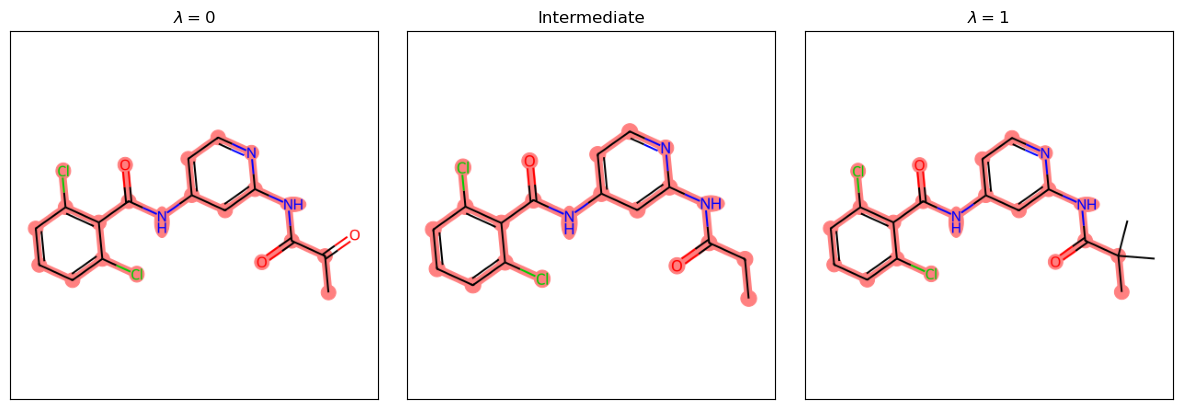

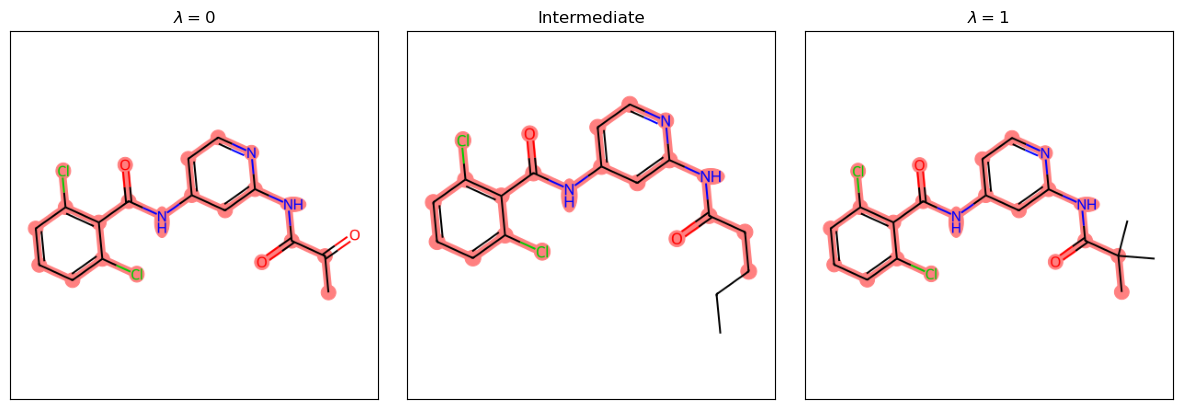

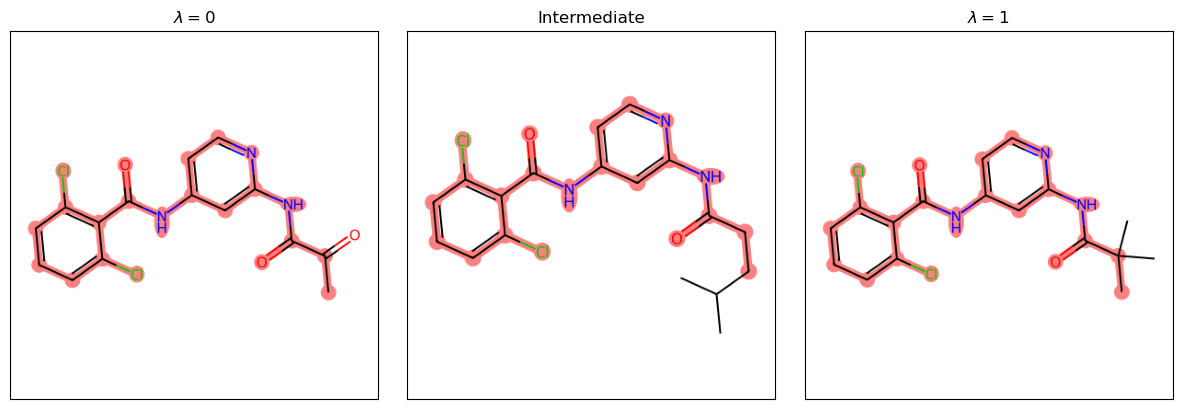

In [61]:
visualise(liga_smiles, ligb_smiles, 'CCC(=O)NC1:C:C(NC(=O)C2:C(Cl):C:C:C:C:2Cl):C:C:N:1')

visualise(liga_smiles, ligb_smiles, 'CCCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')
visualise(liga_smiles, ligb_smiles, 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1')